In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import Model,optimizers,Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, LearningRateScheduler,Callback,TensorBoard
from tensorflow.keras.layers import BatchNormalization

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sub_list = os.listdir('CGR/CIP_CGR_outputs')
X, Y = [], []
for f in sub_list:
    sub_file = os.path.join('CGR/CIP_CGR_outputs', f)
    file_list = os.listdir(sub_file)
    if f == '0':
        Y += [0]*len(file_list)
    if f == '1':
        Y += [1]*len(file_list)
    for name in file_list:
        X.append(img_to_array(load_img(os.path.join(sub_file, name))))
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((1650, 224, 224, 3), (1650,))

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

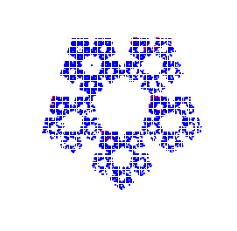

In [13]:
# patches=Patches(patch_size=7)(X[0].reshape(1,X.shape[1],X.shape[2],X.shape[3]))
# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (7, 7, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")


In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = s(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
X=preprocess_input(X)
Y=to_categorical(Y,2)
X.shape,X.dtype,Y.shape,Y.dtype

((1650, 224, 224, 3), dtype('float32'), (1650, 2), dtype('float32'))

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1320, 224, 224, 3), (330, 224, 224, 3), (1320, 2), (330, 2))

In [8]:
Drug_name='CIP'
batch_size = 32
classes = 2
epochs = 100
warm_up=int(epochs*0.8)
verbosity = 1
# max_seq_len=X.shape[1]
lr=0.00001
# img_size=X.shape[1]
img_size=224
# img_channel=X.shape[-1]
img_channel=3
# check_dir=f"./results/{Bacteria}/{Encoding}"
# os.mkdir(check_dir)
# if not os.path.exists(check_dir): os.mkdir(check_dir)
# checkpoints=f"./results/{Bacteria}/{Encoding}/{Bacteria}_{Mode}_{Encoding}_{Method}_{Drug_name}_BESTMODEL.h5"
checkpoints=f"BESTMODEL.h5"

In [9]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    bn_name = (name + '_bn') if name else None
    conv_name = name + '_conv' if name else None

    x = layers.Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x

In [10]:
def BottleNeck(inputs,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inputs, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inputs, nb_filter=k3, strides=strides, kernel_size=1)
        x = layers.add([x, shortcut])
        return x
    else:
        x = layers.add([x, inputs])
        return x

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.01),
        # preprocessing.RandomTranslation(height_factor=0.01, width_factor=0.01),
        # preprocessing.RandomFlip(),
        # preprocessing.RandomContrast(factor=0.01),
    ],
    name="img_augmentation",
)

In [12]:
inputs = layers.Input(shape=(img_size, img_size, img_channel))
# x=img_augmentation(inputs)
x = layers.ZeroPadding2D((3, 3))(inputs)
x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
x = layers. MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = BottleNeck(x, nb_filters=[64, 64, 256], strides=(1, 1), with_conv_shortcut=True)
x = BottleNeck(x, nb_filters=[64, 64, 256])
x = BottleNeck(x, nb_filters=[64, 64, 256])
# x = BottleNeck(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
# x = BottleNeck(x, nb_filters=[128, 128, 512])
# x = BottleNeck(x, nb_filters=[128, 128, 512])
# x = BottleNeck(x, nb_filters=[128, 128, 512])
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
# x=layers.Dropout(0.3)(x)
outputs = layers.Dense(classes, activation='softmax')(x)
print(outputs.shape)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])


(None, 2)


In [13]:
def scheduler(epoch, lr):
  if epoch < warm_up:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [14]:
checkpointer = ModelCheckpoint(checkpoints, monitor='val_accuracy', verbose=verbosity, save_best_only=True, mode='max')
LR_Scheduler = LearningRateScheduler(schedule=scheduler)
tb = TensorBoard(log_dir='./TensorBoard', update_freq='epoch')


In [15]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbosity,
    validation_data=(x_test, y_test),
    callbacks=[checkpointer, LR_Scheduler, tb]
)


Epoch 1/100
 1/42 [..............................] - ETA: 0s - loss: 1.6951 - accuracy: 0.1875WARNING:tensorflow:From /home/amax/anaconda3/envs/torchhwk/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7886
Epoch 00001: val_accuracy improved from -inf to 0.24848, saving model to BESTMODEL.h5
42/42 [==============================] - 4s 92ms/step - loss: 0.5567 - accuracy: 0.7886 - val_loss: 0.7370 - val_accuracy: 0.2485
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.8788
Epoch 00002: val_accuracy improved from 0.24848 to 0.61818, saving model to BESTMODEL.h5
42/42 [==============================] - 4s 87ms/step - loss: 0.2934 - accuracy: 0.8788 - val_loss: 0.6872 - val_accuracy

In [16]:
model=load_model(checkpoints)
preds=model.predict(x_test)
print("Result for {}".format(Drug_name))
print(classification_report(y_test.argmax(-1),preds.argmax(-1),target_names=['S','R']))

Result for CIP
              precision    recall  f1-score   support

           S       0.96      0.99      0.98       248
           R       0.97      0.89      0.93        82

    accuracy                           0.97       330
   macro avg       0.97      0.94      0.95       330
weighted avg       0.97      0.97      0.97       330

